In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
    
train_transforms = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=train_transforms, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


AttributeError: partially initialized module 'torch._inductor' has no attribute 'custom_graph_pass' (most likely due to a circular import)

In [2]:
import torch.nn as nn
import torch.nn.functional as F
class VAE(nn.Module):
    def __init__(self, input_size, latent_size, output_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 2*latent_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, output_size),
        )
 
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    def forward(self, x):
        latent = self.encoder(x)
        latent = latent.reshape(-1,2,self.latent_size)
        mu = latent[:,0,:]
        logvar = latent[:,1,:]
        z = self.reparameterize(mu, logvar)
        return F.sigmoid(self.decoder(z)), mu, logvar
    
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # KL Divergence loss (Encourages normal distribution in latent space)

    return recon_loss + 1.2*kl_loss  # Total loss

In [7]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import datetime
now = datetime.datetime.now().strftime("%m_%d-%H_%M_%S")
logger = SummaryWriter(f'runs/VAE/{now}')
latent_size = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = VAE(input_size=784, latent_size=latent_size, output_size=784).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 5
vae.train()

for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)  # Forward pass
        loss = loss_function(recon_batch, data, mu, logvar)  # Compute loss
        loss.backward()
        optimizer.step()
        logger.add_scalar("Loss/train",loss, batch_idx + len(train_loader) * epoch)
        total_loss += loss.item()
    logger.flush()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

print("Training complete!")
logger.close()


W0305 19:57:32.614343 9496 site-packages\torch\_inductor\utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


BackendCompilerFailed: backend='inductor' raised:
RuntimeError: Found NVIDIA GeForce GTX 1070 which is too old to be supported by the triton GPU compiler, which is used as the backend. Triton only supports devices of CUDA Capability >= 7.0, but your device is of CUDA capability 6.1

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


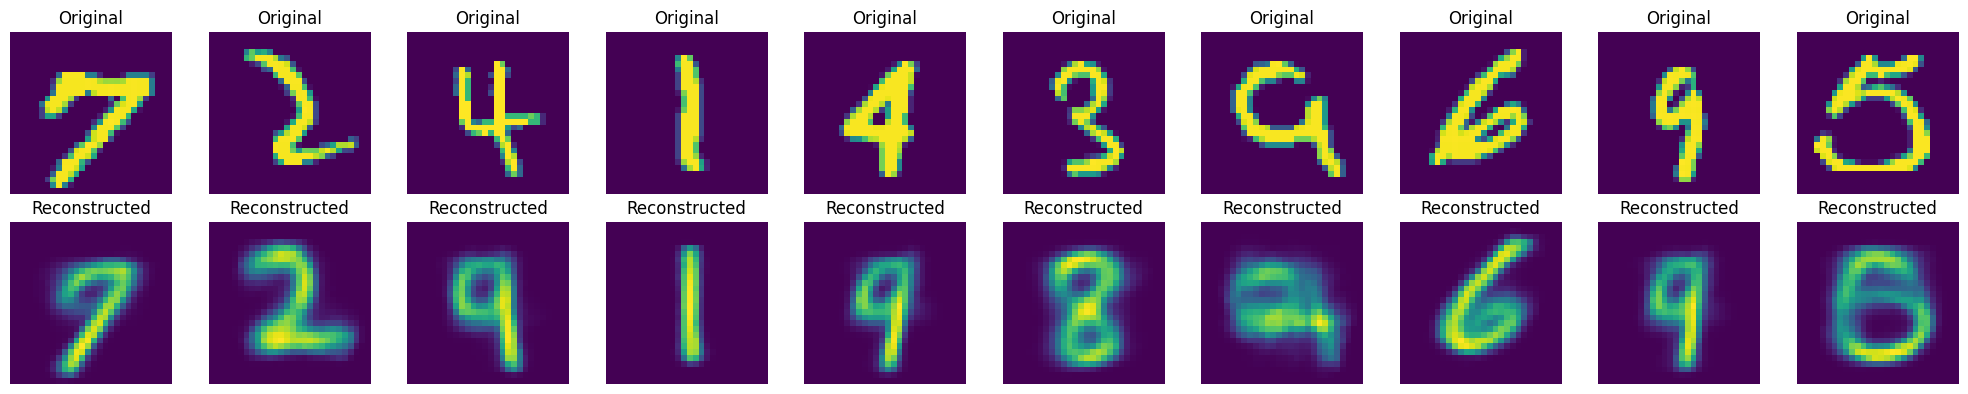

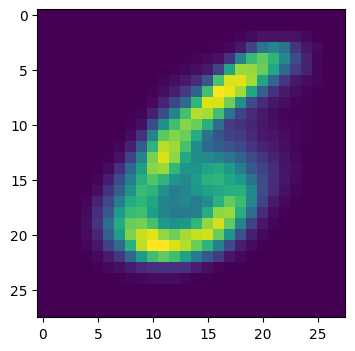

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

def plot_reconstructions(model, dataloader, device, n_images=10):
    """
    Visualize original images alongside their reconstructions from the VAE.
    """
    model.eval()
    images, _ = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        # Reconstruct the images from the VAE
        recon_images,_,_ = model(images)

    # Convert the images to numpy arrays for plotting
    images = images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()
    images = images.reshape(-1, 28, 28)
    recon_images = recon_images.reshape(-1, 28, 28)
    # Plot original vs reconstructed
    fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(20, 4))
    for i in range(n_images):
        # Original images
        axes[0, i].imshow(images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed images
        axes[1, i].imshow(recon_images[i])
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

def plot_random(model):
    model.eval()
    with torch.no_grad():
        x = torch.randn(1,latent_size).to(device)
        result = F.sigmoid(model.decoder(x))
        result = result.cpu().numpy()
        result = result.reshape(-1, 28, 28).squeeze(axis=0)
        fig, axes = plt.subplots(figsize=(4, 4))
        axes.imshow(result)
        plt.show()

plot_reconstructions(vae, test_loader, device)
plot_random(vae)

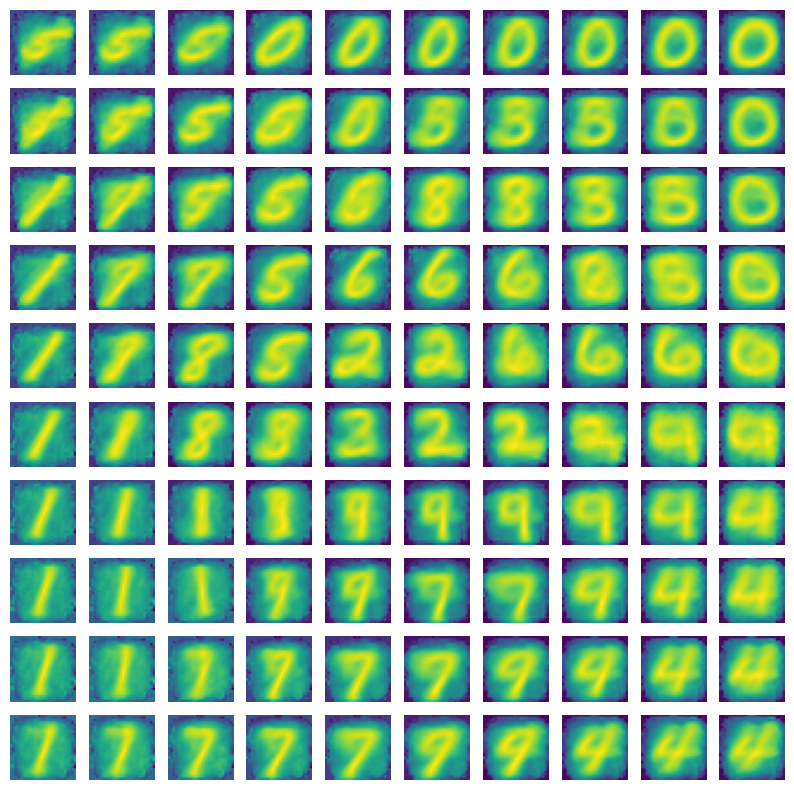

In [6]:
def traverse_latent_space(model, latent_dim, grid_size=10, scale=2.0):
    assert latent_dim == 2, "This visualization only works for 2D latent space"
    
    # Create a grid of latent space points
    grid_x = np.linspace(-scale, scale, grid_size)
    grid_y = np.linspace(-scale, scale, grid_size)
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    
    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_y):
            z = torch.tensor([[x, y]], dtype=torch.float32,device=device)  # Latent vector
            with torch.no_grad():
                img = model.decoder(z).view(28, 28).cpu().numpy()  # Decode
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    
    plt.show()

# Example usage (only works for 2D latent space)
traverse_latent_space(vae, latent_dim=2)
        